## Liver Cirrhosis Detection Using MRI scan datas of the patients


#### Imports and Configs


In [62]:
# ---------- Cell 1: Imports & Config ----------
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (128, 128, 64)
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

# Define PATHS globally
PATHS = {
    'cirrhosis': {
        'train': ('cirrhosis_T1_3D/train_images', 'cirrhosis_T1_3D/train_masks'),
        'val': ('cirrhosis_T1_3D/valid_images', 'cirrhosis_T1_3D/valid_masks'),
        'test': ('cirrhosis_T1_3D/test_images', 'cirrhosis_T1_3D/test_masks')
    },
    'healthy': {
        'images': 'T1_W_Healthy/T1_images',
        'masks': 'T1_W_Healthy/T1_masks'
    }
}

### Data preprocessing 

In [63]:
class LiverDataset(Dataset):
    def __init__(self):
        self.samples = []
        
        # Load cirrhosis cases
        for split in ['train', 'val', 'test']:
            img_dir, mask_dir = PATHS['cirrhosis'][split]
            for fname in os.listdir(img_dir):
                if fname.endswith('.nii'):
                    self.samples.append({
                        'image': os.path.join(img_dir, fname),
                        'mask': os.path.join(mask_dir, fname),
                        'label': 1,
                        'split': split
                    })
        
        # Load healthy cases with verification
        healthy_path = PATHS['healthy']['images']
        healthy_images = [f for f in os.listdir(healthy_path) if f.endswith('.nii')]
        
        print(f"\nFound {len(healthy_images)} healthy images in: {healthy_path}")
        
        if len(healthy_images) > 0:
            # Split healthy cases
            h_train_val, h_test = train_test_split(healthy_images, test_size=0.2, random_state=42)
            h_train, h_val = train_test_split(h_train_val, test_size=0.25, random_state=42)
            
            # Add to splits with verification
            for split_name, files in [('train', h_train), ('val', h_val), ('test', h_test)]:
                print(f"Adding {len(files)} healthy cases to {split_name} split")
                for fname in files:
                    self.samples.append({
                        'image': os.path.join(PATHS['healthy']['images'], fname),
                        'mask': os.path.join(PATHS['healthy']['masks'], fname),
                        'label': 0,
                        'split': split_name
                    })

        # Print final distribution
        print("\nFinal Class Distribution:")
        for split in ['train', 'val', 'test']:
            split_samples = [s for s in self.samples if s['split'] == split]
            print(f"{split.upper():<6} - Healthy: {sum(1 for s in split_samples if s['label']==0)}, "
                  f"Cirrhosis: {sum(1 for s in split_samples if s['label']==1)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = nib.load(sample['image']).get_fdata()
        mask = nib.load(sample['mask']).get_fdata()
        
        # Preprocessing
        processed = self._preprocess(img, mask)
        
        return (
            torch.tensor(processed, dtype=torch.float32).unsqueeze(0),
            torch.tensor(sample['label'], dtype=torch.long)
        )

    def _preprocess(self, img, mask):
        # Mask application
        masked = img * mask
        
        # Normalization
        masked = (masked - masked.min()) / (masked.max() - masked.min() + 1e-8)
        
        # Resizing
        zoom_factors = [IMG_SIZE[i]/masked.shape[i] for i in range(3)]
        resized = zoom(masked, zoom_factors, order=1)
        
        return resized.astype(np.float32)

#### Creating Data loaders


In [64]:
# ---------- Cell 3: Create DataLoaders ----------
full_dataset = LiverDataset()

# Create indices for splits
train_indices = [i for i, s in enumerate(full_dataset.samples) if s['split'] == 'train']
val_indices = [i for i, s in enumerate(full_dataset.samples) if s['split'] == 'val']
test_indices = [i for i, s in enumerate(full_dataset.samples) if s['split'] == 'test']

# Create datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("\nDataLoader sizes:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Found 55 healthy images in: T1_W_Healthy/T1_images
Adding 33 healthy cases to train split
Adding 11 healthy cases to val split
Adding 11 healthy cases to test split

Final Class Distribution:
TRAIN  - Healthy: 33, Cirrhosis: 248
VAL    - Healthy: 11, Cirrhosis: 31
TEST   - Healthy: 11, Cirrhosis: 31

DataLoader sizes:
Train batches: 71
Val batches: 11
Test batches: 11


### Enhanced 3D CNN Model

In [65]:
# ---------- Cell 4: Enhanced 3D CNN Model ----------
class LiverNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

### Model traing with validation Checks 

In [66]:
# ---------- Cell 5: Training with Validation Checks & Model Saving ----------
import os
from datetime import datetime

def save_model(model, history=None):
    """Save model with timestamp to prevent overwriting"""
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save full model architecture + weights
    model_path = os.path.join(save_dir, f"liver_model_{timestamp}.pth")
    torch.save(model, model_path)
    
    # Save weights only (for production)
    weights_path = os.path.join(save_dir, f"liver_weights_{timestamp}.pth")
    torch.save(model.state_dict(), weights_path)
    
    # Save training history
    if history is not None:
        history_path = os.path.join(save_dir, f"training_history_{timestamp}.pt")
        torch.save(history, history_path)
    
    print(f"\nModel saved to: {model_path}")
    print(f"Weights saved to: {weights_path}")
    if history is not None:
        print(f"Training history saved to: {history_path}")

def train_model():
    model = LiverNet().to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    best_metrics = {'val_loss': float('inf'), 'epoch': -1}
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_auc': []
    }
    
    print("\n=== Training Initialization ===")
    print(f"Device: {DEVICE}")
    print(f"Training Samples: {len(train_dataset)}")
    print(f"Validation Samples: {len(val_dataset)}")
    print(f"Epochs: {EPOCHS}")
    print(f"Learning Rate: {LEARNING_RATE}\n")
    
    for epoch in range(EPOCHS):
        # Training Phase
        model.train()
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                all_probs.extend(probs[:, 1].cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        val_auc = roc_auc_score(all_labels, all_probs)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        # Save best model weights
        if avg_val_loss < best_metrics['val_loss']:
            best_metrics = {
                'val_loss': avg_val_loss,
                'epoch': epoch,
                'state_dict': model.state_dict()
            }
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision/Recall: {val_precision:.4f}/{val_recall:.4f}")
        print(f"F1 Score: {val_f1:.4f} | AUC: {val_auc:.4f}")
        print("-" * 60)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
    
    # Final save with timestamp
    print("\n=== Training Complete ===")
    print(f"Best Validation Loss: {best_metrics['val_loss']:.4f} (Epoch {best_metrics['epoch']+1})")
    
    # Load best weights before final save
    model.load_state_dict(torch.load('best_model.pth'))
    save_model(model, history)
    
    # Cleanup temporary file
    if os.path.exists('best_model.pth'):
        os.remove('best_model.pth')
    
    return model, history

# Run training and save automatically
model, history = train_model()


=== Training Initialization ===
Device: cpu
Training Samples: 281
Validation Samples: 42
Epochs: 30
Learning Rate: 0.0001



Epoch 1/30: 100%|██████████| 71/71 [07:55<00:00,  6.70s/batch, loss=0.0001]



Epoch 1/30 Summary:
Train Loss: 0.9758
Val Loss: 0.8729 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.7537
------------------------------------------------------------


Epoch 2/30: 100%|██████████| 71/71 [07:09<00:00,  6.06s/batch, loss=3.1927]



Epoch 2/30 Summary:
Train Loss: 0.7860
Val Loss: 1.1806 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.7537
------------------------------------------------------------


Epoch 3/30: 100%|██████████| 71/71 [07:17<00:00,  6.17s/batch, loss=0.0535]



Epoch 3/30 Summary:
Train Loss: 0.5116
Val Loss: 0.6836 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.7507
------------------------------------------------------------


Epoch 4/30: 100%|██████████| 71/71 [07:09<00:00,  6.04s/batch, loss=0.0330]



Epoch 4/30 Summary:
Train Loss: 0.4669
Val Loss: 0.6731 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.8299
------------------------------------------------------------


Epoch 5/30: 100%|██████████| 71/71 [06:54<00:00,  5.84s/batch, loss=0.1350]



Epoch 5/30 Summary:
Train Loss: 0.3717
Val Loss: 0.6555 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.8563
------------------------------------------------------------


Epoch 6/30: 100%|██████████| 71/71 [06:53<00:00,  5.83s/batch, loss=0.0109]



Epoch 6/30 Summary:
Train Loss: 0.3653
Val Loss: 0.6597 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.8592
------------------------------------------------------------


Epoch 7/30: 100%|██████████| 71/71 [3:56:27<00:00, 199.83s/batch, loss=0.1950]    



Epoch 7/30 Summary:
Train Loss: 0.3502
Val Loss: 0.6927 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.9120
------------------------------------------------------------


Epoch 8/30: 100%|██████████| 71/71 [07:19<00:00,  6.19s/batch, loss=0.7994]



Epoch 8/30 Summary:
Train Loss: 0.3479
Val Loss: 0.5180 | Val Acc: 0.7619
Precision/Recall: 0.7561/1.0000
F1 Score: 0.8611 | AUC: 0.8768
------------------------------------------------------------


Epoch 9/30: 100%|██████████| 71/71 [06:55<00:00,  5.86s/batch, loss=0.2661]



Epoch 9/30 Summary:
Train Loss: 0.2821
Val Loss: 0.5455 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.9267
------------------------------------------------------------


Epoch 10/30: 100%|██████████| 71/71 [07:04<00:00,  5.98s/batch, loss=0.0047]



Epoch 10/30 Summary:
Train Loss: 0.3004
Val Loss: 0.3967 | Val Acc: 0.7619
Precision/Recall: 0.7838/0.9355
F1 Score: 0.8529 | AUC: 0.9208
------------------------------------------------------------


Epoch 11/30: 100%|██████████| 71/71 [07:46<00:00,  6.58s/batch, loss=0.2313]



Epoch 11/30 Summary:
Train Loss: 0.2922
Val Loss: 0.4303 | Val Acc: 0.7619
Precision/Recall: 0.7692/0.9677
F1 Score: 0.8571 | AUC: 0.9296
------------------------------------------------------------


Epoch 12/30: 100%|██████████| 71/71 [08:00<00:00,  6.76s/batch, loss=0.1153]



Epoch 12/30 Summary:
Train Loss: 0.2622
Val Loss: 0.6243 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.8739
------------------------------------------------------------


Epoch 13/30: 100%|██████████| 71/71 [10:16<00:00,  8.69s/batch, loss=0.1157]



Epoch 13/30 Summary:
Train Loss: 0.2793
Val Loss: 0.5665 | Val Acc: 0.7381
Precision/Recall: 0.7381/1.0000
F1 Score: 0.8493 | AUC: 0.9062
------------------------------------------------------------


Epoch 14/30: 100%|██████████| 71/71 [07:50<00:00,  6.63s/batch, loss=0.0002]



Epoch 14/30 Summary:
Train Loss: 0.2043
Val Loss: 0.4530 | Val Acc: 0.8333
Precision/Recall: 0.8529/0.9355
F1 Score: 0.8923 | AUC: 0.8886
------------------------------------------------------------


Epoch 15/30: 100%|██████████| 71/71 [11:05<00:00,  9.38s/batch, loss=0.1489]



Epoch 15/30 Summary:
Train Loss: 0.1505
Val Loss: 0.5883 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9003
------------------------------------------------------------


Epoch 16/30: 100%|██████████| 71/71 [07:57<00:00,  6.72s/batch, loss=0.0004]



Epoch 16/30 Summary:
Train Loss: 0.1439
Val Loss: 0.5371 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 17/30: 100%|██████████| 71/71 [10:59:34<00:00, 557.39s/batch, loss=0.0221]      



Epoch 17/30 Summary:
Train Loss: 0.1316
Val Loss: 0.5470 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 18/30: 100%|██████████| 71/71 [07:31<00:00,  6.36s/batch, loss=0.0008]



Epoch 18/30 Summary:
Train Loss: 0.1419
Val Loss: 0.5814 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9120
------------------------------------------------------------


Epoch 19/30: 100%|██████████| 71/71 [07:19<00:00,  6.20s/batch, loss=0.0014]



Epoch 19/30 Summary:
Train Loss: 0.1242
Val Loss: 0.5709 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 20/30: 100%|██████████| 71/71 [07:05<00:00,  6.00s/batch, loss=0.0000]



Epoch 20/30 Summary:
Train Loss: 0.1193
Val Loss: 0.5611 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 21/30: 100%|██████████| 71/71 [07:07<00:00,  6.02s/batch, loss=0.0007]



Epoch 21/30 Summary:
Train Loss: 0.1117
Val Loss: 0.5704 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 22/30: 100%|██████████| 71/71 [1:13:39<00:00, 62.24s/batch, loss=0.0522]     



Epoch 22/30 Summary:
Train Loss: 0.1085
Val Loss: 0.5727 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 23/30: 100%|██████████| 71/71 [07:40<00:00,  6.49s/batch, loss=0.2961]



Epoch 23/30 Summary:
Train Loss: 0.1068
Val Loss: 0.5664 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 24/30: 100%|██████████| 71/71 [07:11<00:00,  6.08s/batch, loss=0.0001]



Epoch 24/30 Summary:
Train Loss: 0.1021
Val Loss: 0.5709 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 25/30: 100%|██████████| 71/71 [07:23<00:00,  6.25s/batch, loss=0.0012]



Epoch 25/30 Summary:
Train Loss: 0.1081
Val Loss: 0.5622 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 26/30: 100%|██████████| 71/71 [07:25<00:00,  6.28s/batch, loss=0.2669]



Epoch 26/30 Summary:
Train Loss: 0.1321
Val Loss: 0.5674 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 27/30: 100%|██████████| 71/71 [07:07<00:00,  6.03s/batch, loss=0.3844]



Epoch 27/30 Summary:
Train Loss: 0.1191
Val Loss: 0.5599 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 28/30: 100%|██████████| 71/71 [07:05<00:00,  6.00s/batch, loss=0.0038]



Epoch 28/30 Summary:
Train Loss: 0.1159
Val Loss: 0.5716 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 29/30: 100%|██████████| 71/71 [13:45<00:00, 11.63s/batch, loss=0.0066]   



Epoch 29/30 Summary:
Train Loss: 0.1273
Val Loss: 0.5606 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9150
------------------------------------------------------------


Epoch 30/30: 100%|██████████| 71/71 [07:30<00:00,  6.35s/batch, loss=0.0002]



Epoch 30/30 Summary:
Train Loss: 0.1433
Val Loss: 0.5646 | Val Acc: 0.7857
Precision/Recall: 0.7895/0.9677
F1 Score: 0.8696 | AUC: 0.9179
------------------------------------------------------------

=== Training Complete ===
Best Validation Loss: 0.3967 (Epoch 10)

Model saved to: saved_models\liver_model_20250502_191336.pth
Weights saved to: saved_models\liver_weights_20250502_191336.pth
Training history saved to: saved_models\training_history_20250502_191336.pt


## Preformance Parameter analysis

In [ ]:
# ---------- Cell 6: Advanced Performance Analysis ----------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                            confusion_matrix, classification_report)

def load_best_model():
    model = LiverNet().to(DEVICE)
    model.load_state_dict(torch.load('saved_models/liver_weights_20250502_191336.pth'))
    return model

def plot_training_history(history):
    plt.figure(figsize=(18, 6))
    
    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy and AUC Plot
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Accuracy')
    plt.plot(history['val_auc'], label='AUC')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    
    # Precision-Recall-F1 Plot
    plt.subplot(1, 3, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.plot(history['val_f1'], label='F1 Score')
    plt.title('Precision/Recall/F1 Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def comprehensive_evaluation(model, loader, set_name='Test'):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate comprehensive report
    print(f"\n=== {set_name} Set Evaluation ===")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Cirrhosis']))
    
    # Confusion Matrix
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Cirrhosis'], 
                yticklabels=['Healthy', 'Cirrhosis'])
    plt.title(f'{set_name} Set Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{set_name} Set ROC Curve')
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{set_name} Set Precision-Recall Curve')
    plt.show()
    
    return {
        'labels': all_labels,
        'preds': all_preds,
        'probs': all_probs,
        'roc_auc': roc_auc
    }

## Model Testing



=== Training History Analysis ===


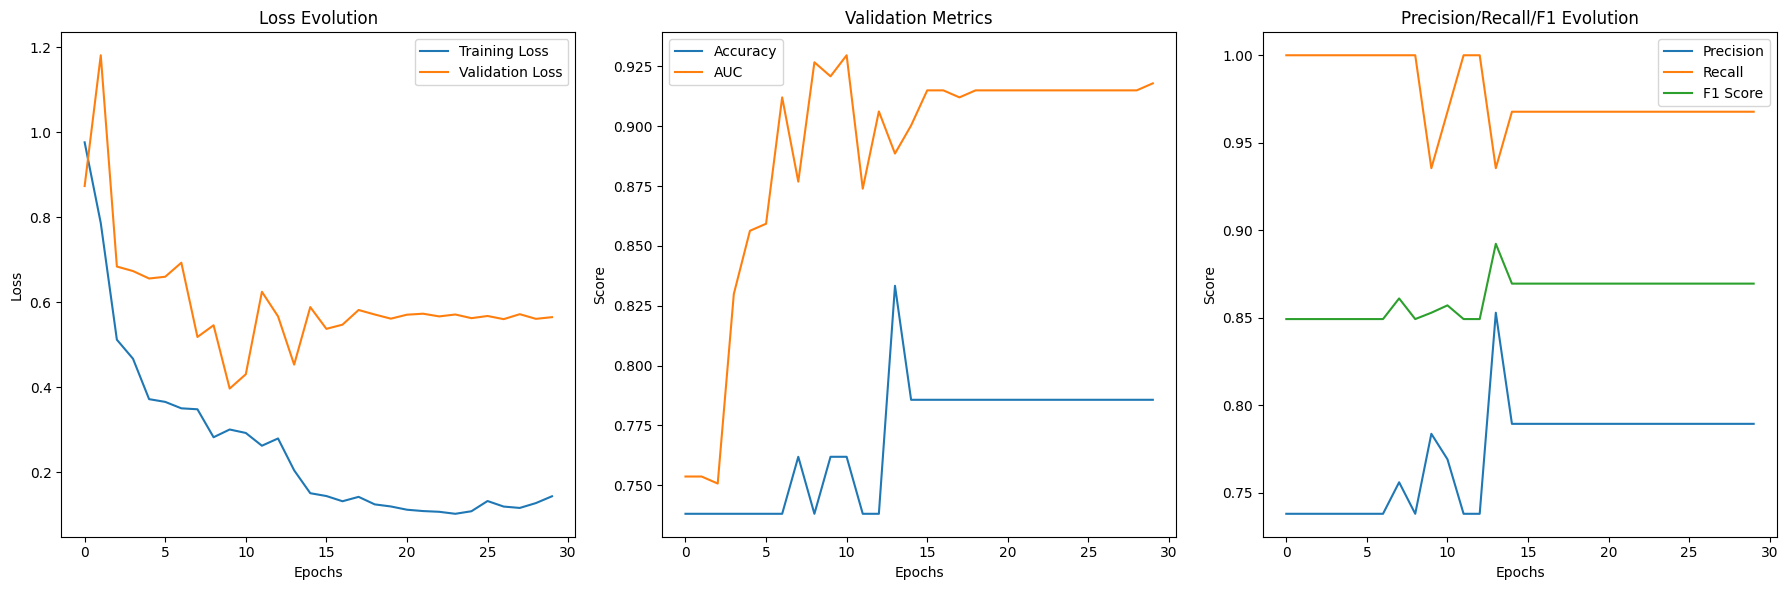


=== Combined Test Set Evaluation ===

=== Combined Test Set Evaluation ===

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.60      0.27      0.38        11
   Cirrhosis       0.78      0.94      0.85        31

    accuracy                           0.76        42
   macro avg       0.69      0.60      0.61        42
weighted avg       0.74      0.76      0.73        42



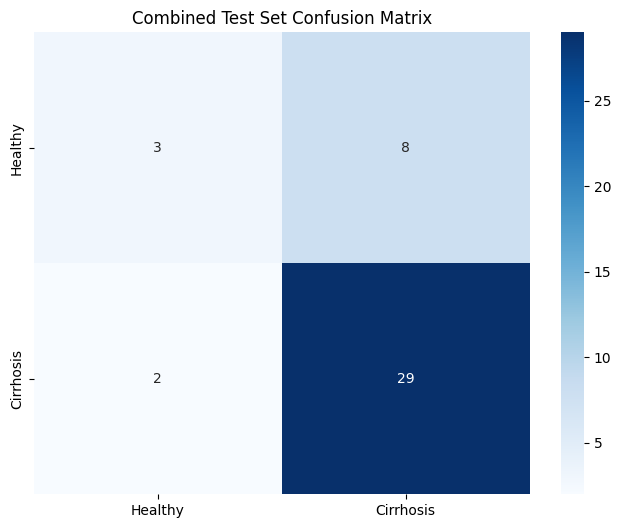

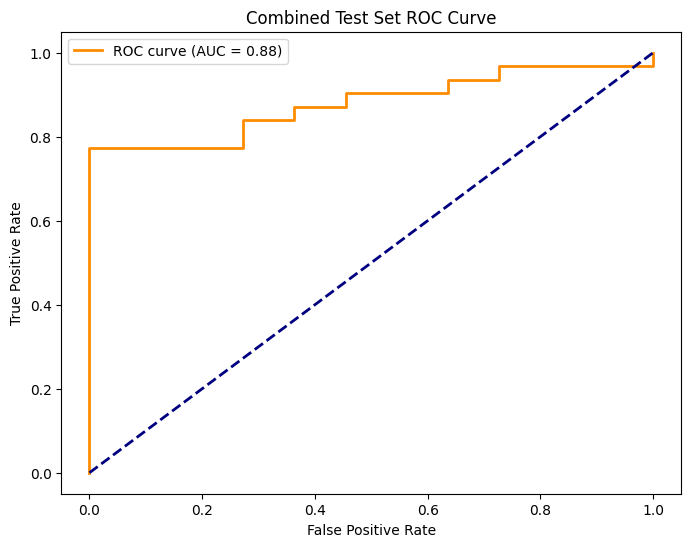

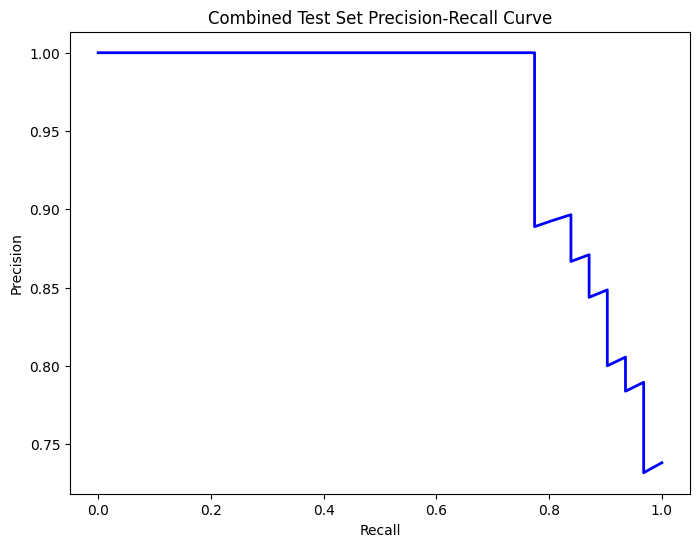


=== Healthy Test Cases Evaluation ===

=== Healthy Test Set Evaluation ===

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.27      0.43        11
   Cirrhosis       0.00      0.00      0.00         0

    accuracy                           0.27        11
   macro avg       0.50      0.14      0.21        11
weighted avg       1.00      0.27      0.43        11



g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


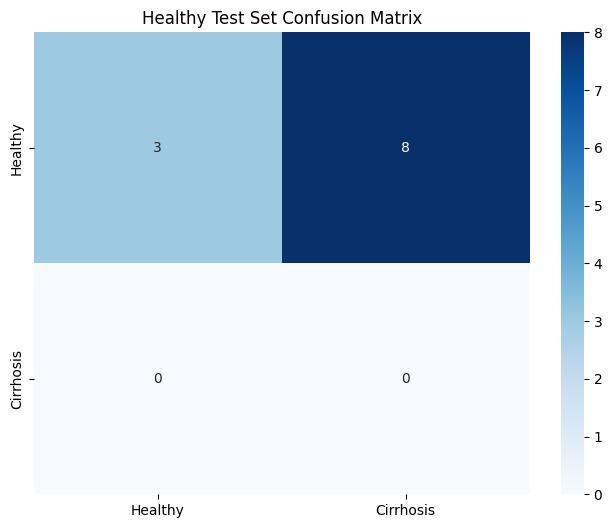

g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


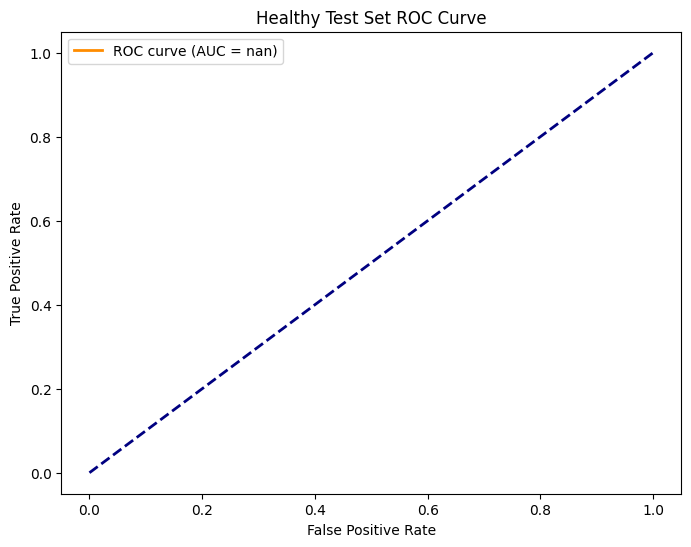

g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


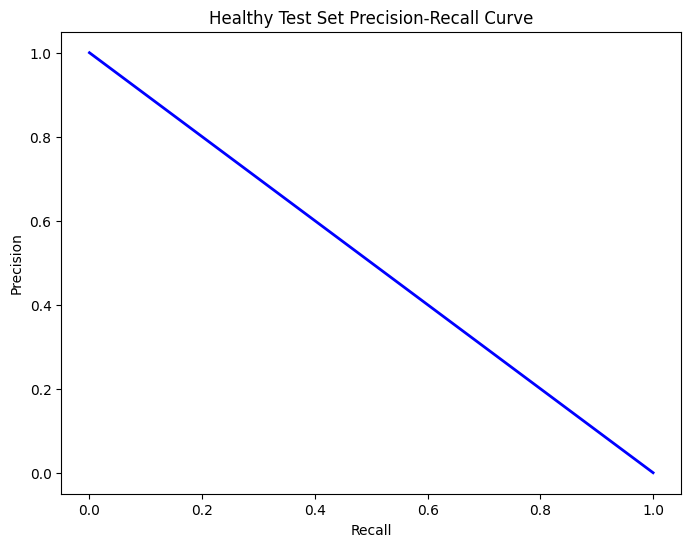


=== Cirrhosis Test Cases Evaluation ===

=== Cirrhosis Test Set Evaluation ===

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         0
   Cirrhosis       1.00      0.94      0.97        31

    accuracy                           0.94        31
   macro avg       0.50      0.47      0.48        31
weighted avg       1.00      0.94      0.97        31



g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


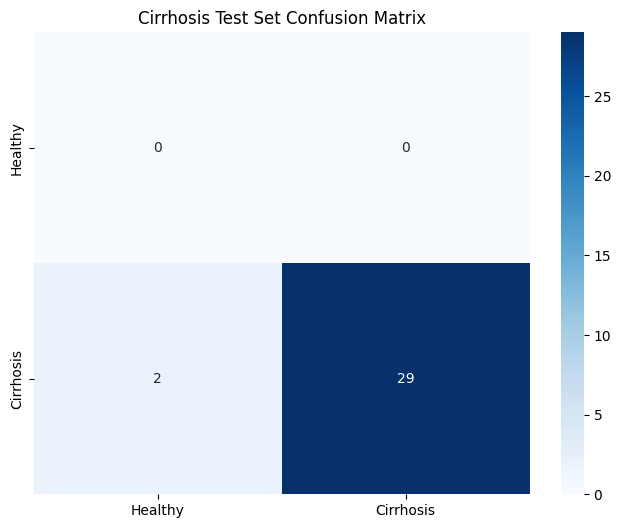

g:\Liver_chirrhosis prediction\liver_env\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


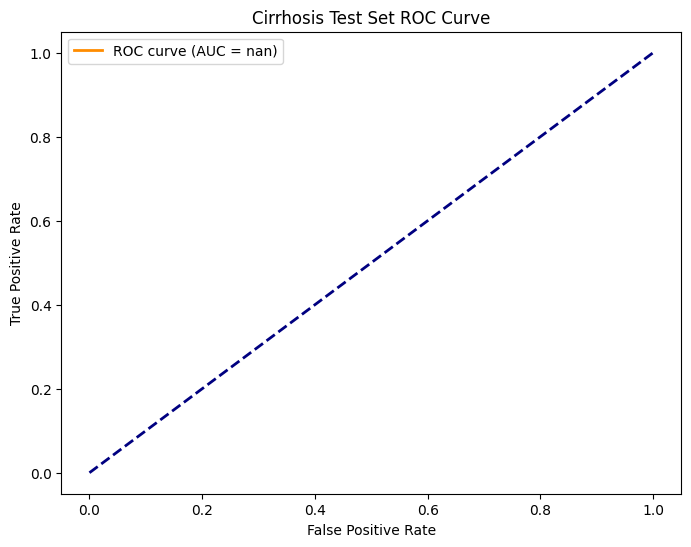

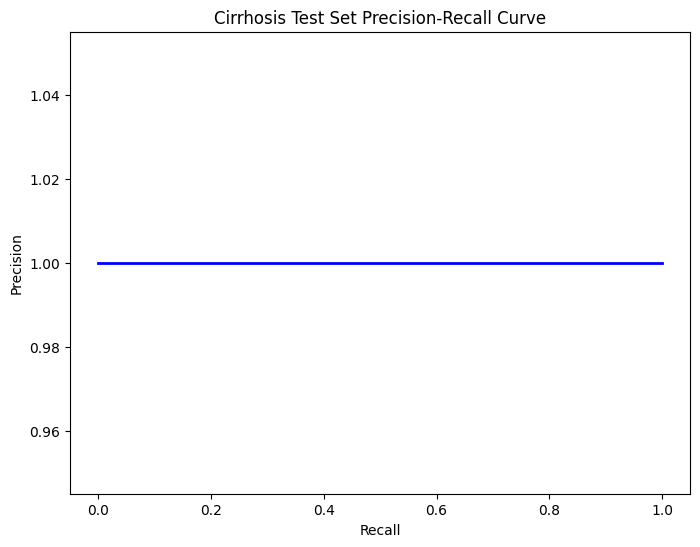

In [77]:
# ---------- Cell 7: Model Testing Execution ----------
# Load best model
model = load_best_model()

# Analyze training history
print("\n=== Training History Analysis ===")
plot_training_history(history)

# Full dataset evaluation
print("\n=== Combined Test Set Evaluation ===")
test_results = comprehensive_evaluation(model, test_loader, 'Combined Test')

# Healthy cases only evaluation
healthy_indices = [i for i, s in enumerate(full_dataset.samples) 
                   if s['split'] == 'test' and s['label'] == 0]
healthy_loader = DataLoader(Subset(full_dataset, healthy_indices), batch_size=BATCH_SIZE)

print("\n=== Healthy Test Cases Evaluation ===")
healthy_results = comprehensive_evaluation(model, healthy_loader, 'Healthy Test')

# Cirrhosis cases only evaluation
cirrhosis_indices = [i for i, s in enumerate(full_dataset.samples) 
                     if s['split'] == 'test' and s['label'] == 1]
cirrhosis_loader = DataLoader(Subset(full_dataset, cirrhosis_indices), batch_size=BATCH_SIZE)

print("\n=== Cirrhosis Test Cases Evaluation ===")
cirrhosis_results = comprehensive_evaluation(model, cirrhosis_loader, 'Cirrhosis Test')

## Error Analysis


=== Error Analysis ===

Error Analysis: Found 10 misclassified samples


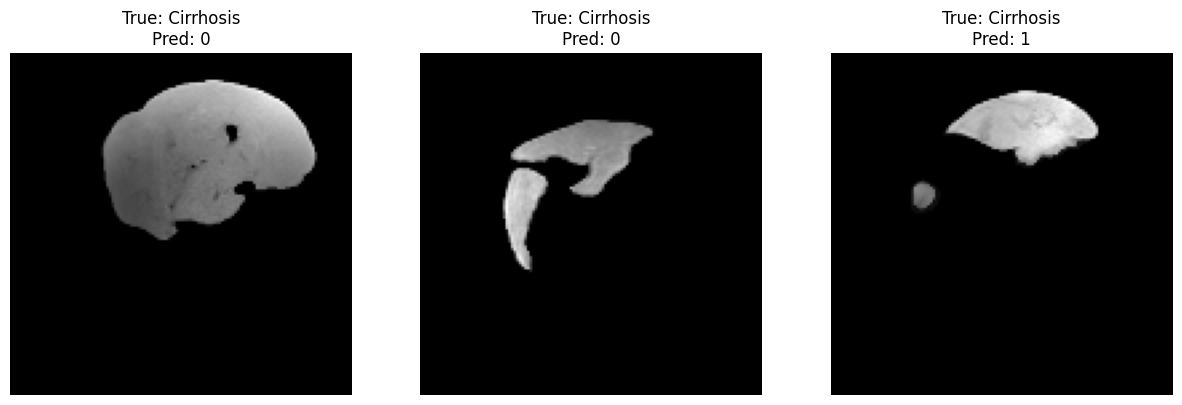

In [78]:
# ---------- Cell 8: Advanced Error Analysis ----------
def error_analysis(results, dataset, num_samples=3):
    incorrect_indices = np.where(np.array(results['preds']) != np.array(results['labels']))[0]
    
    print(f"\nError Analysis: Found {len(incorrect_indices)} misclassified samples")
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(incorrect_indices[:num_samples]):
        sample = dataset[idx]
        image = sample[0].numpy().squeeze()
        
        # Plot middle slices
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image[:, :, image.shape[2]//2], cmap='gray')
        plt.title(f"True: {'Cirrhosis' if sample[1] else 'Healthy'}\nPred: {results['preds'][idx]}")
        plt.axis('off')
    
    plt.show()

print("\n=== Error Analysis ===")
error_analysis(test_results, full_dataset)


## Confidence Analysis


=== Model Confidence Analysis ===


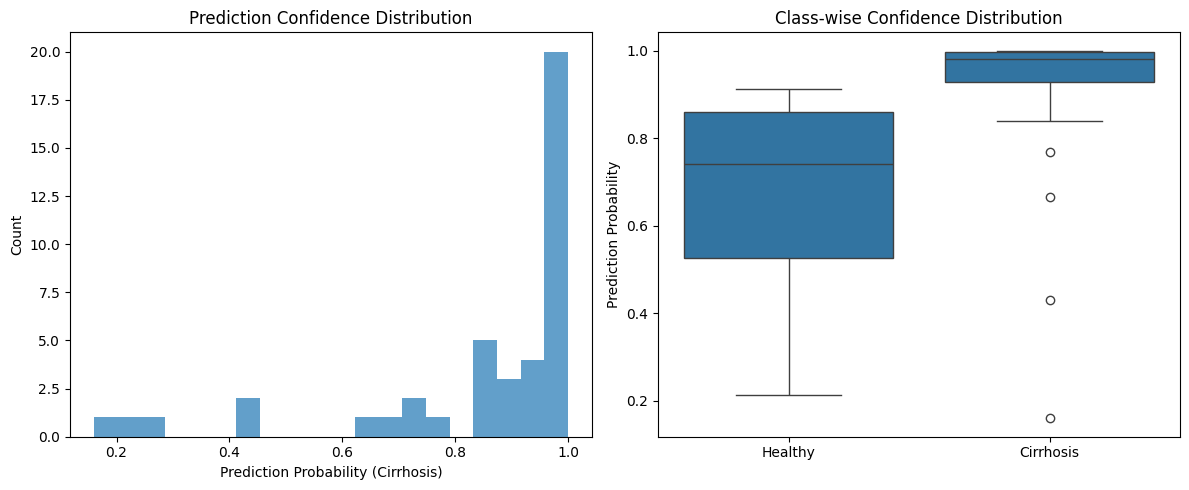

In [79]:
# ---------- Cell 9: Model Confidence Analysis ----------
def plot_confidence_distribution(results):
    plt.figure(figsize=(12, 5))
    
    # Histogram of prediction probabilities
    plt.subplot(1, 2, 1)
    plt.hist(results['probs'], bins=20, alpha=0.7)
    plt.xlabel('Prediction Probability (Cirrhosis)')
    plt.ylabel('Count')
    plt.title('Prediction Confidence Distribution')
    
    # Boxplot by class
    plt.subplot(1, 2, 2)
    sns.boxplot(x=results['labels'], y=results['probs'])
    plt.xticks([0, 1], ['Healthy', 'Cirrhosis'])
    plt.ylabel('Prediction Probability')
    plt.title('Class-wise Confidence Distribution')
    
    plt.tight_layout()
    plt.show()

print("\n=== Model Confidence Analysis ===")
plot_confidence_distribution(test_results)